In [1]:
from pcgym import make_env
import numpy as np
import random

# Control Club Challenge (PSE) 
## 1. Control Problem

The environment used in the this problem is a Continuously Stirred Tank Reactor (CSTR) performing an exothermic reaction (A → B). The controlled variable with be the concentration of species A by manipulating the temperature of the cooling jacket. A diagram of the environment is given below.

<div style="text-align:center">
  <img src="..\docs\img\CSTR_PFD.png" alt="CSTR" width="400">
</div>

### Problem Definition

You must design a control policy which maximises the reward defined by the square error between the state $C_A$ for the environment below. There is also a disturbance to the input feed concentration $C_{A,IN}$ which happens around 9 minutes into the episode.  



## 2. Challenge Environment

First define the challenge environment

In [2]:
# DO NOT CHANGE!
T = 26
nsteps = 120

SP = {
    'Ca': [0.85 for i in range(int(nsteps/4))] + [0.9 for i in range(int(3*nsteps/4))],
}

disturbance = {'Caf': np.repeat([1, 1.05, 1], [nsteps//3, nsteps//3, nsteps//3])}

action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}
#Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}
disturbance_space ={
  'low': np.array([1]),
  'high': np.array([1.05])
}
env_params = {
    'N': nsteps, 
    'tsim':T, 
    'SP':SP, 
    'o_space' : observation_space, 
    'a_space' : action_space,
    'x0': np.array([0.8,330,0.8]),
    'r_scale': {'Ca':1e3},
    'model': 'cstr', 
    'normalise_a': True, 
    'normalise_o':True, 
    'noise':True, 
    'integration_method': 'casadi', 
    'noise_percentage':0.001, 
    'disturbance_bounds':disturbance_space,
    'disturbances': disturbance
}
env = make_env(env_params)

/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## 3. Example Policy and Rollout

An example policy which returns an action from an uniform distribution between the upper and lower control bounds.


$\pi = \mathcal U(u_{lb},u_{ub})$ 

In [3]:
# DO NOT CHANGE!
T = 26
nsteps = 120

SP = {
    'Ca': [0.85 for i in range(int(nsteps/4))] + [0.9 for i in range(int(3*nsteps/4))],
}

disturbance = {'Caf': np.repeat([1, 1.05, 1], [nsteps//3, nsteps//3, nsteps//3])}

action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}
#Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}
disturbance_space ={
  'low': np.array([1]),
  'high': np.array([1.05])
}
env_params = {
    'N': nsteps, 
    'tsim':T, 
    'SP':SP, 
    'o_space' : observation_space, 
    'a_space' : action_space,
    'x0': np.array([0.8,330,0.8]),
    'r_scale': {'Ca':1e3},
    'model': 'cstr', 
    'normalise_a': True, 
    'normalise_o':True, 
    'noise':True, 
    'integration_method': 'casadi', 
    'noise_percentage':0.001, 
    'disturbance_bounds':disturbance_space,
    'disturbances': disturbance
}
# env = make_env(env_params)

In [3]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3 import SAC
from pcgym import make_env


class SB3Wrapper(gym.Env):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.step_count = 0
        self.max_steps = env.N

        # Direct spaces from pcgym (already normalized)
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def reset(self, seed=None, options=None):
        self.step_count = 0
        obs, info = self.env.reset()
        return obs.astype(np.float32), info

    def step(self, action):
        self.step_count += 1

        obs, reward, done, info = self.env.step(action)

        terminated = bool(done)
        truncated = self.step_count >= self.max_steps

        return obs.astype(np.float32), reward, terminated, truncated, info



    def normalize_action(self, a_scaled):
        # Convert [-1, 1] → [low, high]
        return self.action_low + (a_scaled + 1) * 0.5 * (self.action_high - self.action_low)

    def reset(self, seed=None, options=None):
        self.step_count = 0
        obs, info = self.env.reset()
        return np.asarray(obs, dtype=np.float32), info

    def step(self, action):
        self.step_count += 1

        # Convert SB3 action → real Tc value
        real_action = self.normalize_action(action)[0]

        obs, reward, done, info = self.env.step(real_action)

        terminated = bool(done)
        truncated = self.step_count >= self.max_steps

        return (
            np.asarray(obs, dtype=np.float32),
            reward,
            terminated,
            truncated,
            info
        )
    
env_raw = make_env(env_params)
env = SB3Wrapper(env_raw)

model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    buffer_size=100000,
    batch_size=256,
)

model.learn(total_timesteps=200_000)
model.save("sac_cstr")

obs, info = env.reset()
for _ in range(300):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    print(obs, action)
    if terminated or truncated:
        obs, info = env.reset()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/envs/Python31211/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


AttributeError: 'SB3Wrapper' object has no attribute 'action_low'

In [5]:
env_raw = make_env(env_params)
print("OBS SPACE:", env_raw.observation_space)
print("OBS LOW:", env_raw.observation_space.low)
print("OBS HIGH:", env_raw.observation_space.high)
print("ACT SPACE:", env_raw.action_space)
print("ACT LOW:", env_raw.action_space.low)
print("ACT HIGH:", env_raw.action_space.high)

OBS SPACE: Box(-1.0, 1.0, (4,), float32)
OBS LOW: [-1. -1. -1. -1.]
OBS HIGH: [1. 1. 1. 1.]
ACT SPACE: Box(-1.0, 1.0, (1,), float32)
ACT LOW: [-1.]
ACT HIGH: [1.]


In [8]:
# class policy:
#     def predict(self,deterministic = False):
#         return random.uniform(-1, 1), 0
    
import gymnasium as gym
from stable_baselines3 import SAC

model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=4)
model.save("sac_CRST")
obs ,info = env.reset()

while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | -96.4    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 75       |
|    time_elapsed    | 6        |
|    total_timesteps | 476      |
| train/             |          |
|    actor_loss      | -0.0928  |
|    critic_loss     | 0.142    |
|    ent_coef        | 0.894    |
|    ent_coef_loss   | -0.188   |
|    learning_rate   | 0.0003   |
|    n_updates       | 375      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | -86.3    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 65       |
|    time_elapsed    | 14       |
|    total_timesteps | 952      |
| train/             |

KeyboardInterrupt: 

Rollout random policy using the `plot_rollout` method which plots the rollout of the policy, and returns the rollout data and evaluator class. The policy can be plotted with an oracle (MPC with perfect model) which gives you a indication about the optimal control trajectory may look like. Note you can also intract with the environment like you would with any OpenAI gym :).

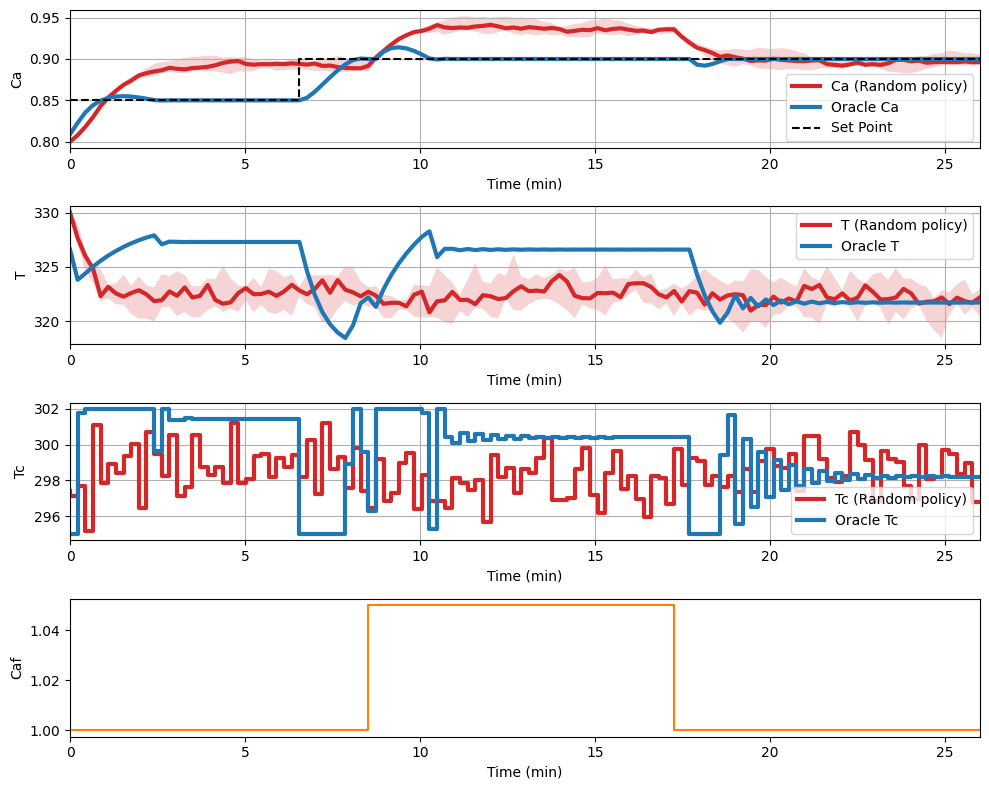

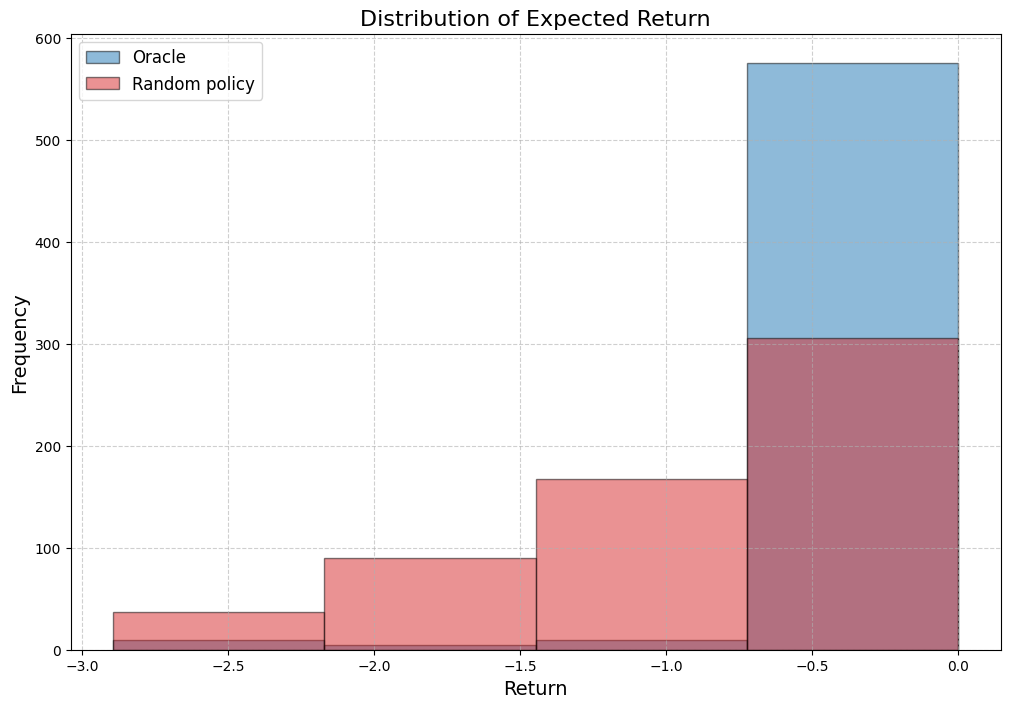

In [ ]:
data, eval = env.plot_rollout(model, reps = 5, oracle = True, dist_reward=True)

## 3. Your Implementation!
Some helpful resourses:
  - [Stable Baselines](https://stable-baselines3.readthedocs.io/en/master/) - Off the shelf implementations of common RL algorithms
 -  [Minimal RL ](https://github.com/seungeunrho/minimalRL) - Minimal versions of common RL algorithms (useful for understanding how to translate the algorithms into code)
 -  [Spinning Up in DRL](https://spinningup.openai.com/en/latest/index.html) - More implememtations from OpenAI
 - [Gymnasium](https://gymnasium.farama.org/) - The environment framework which pc-gym is built on
 - [pc-gym documentation](https://maximilianb2.github.io/pc-gym/) - The docs!

In [ ]:
# Implement your RL algorithm  here! (We've Implemented a simple proportional controller to get you started)
class policy:
    def __init__(self) -> None:
        pass
    def predict(s,deterministic = False):
        kp = 0.75
        u = -1*kp*(s[2] - s[0]) 
        return u, s

# 4. Results

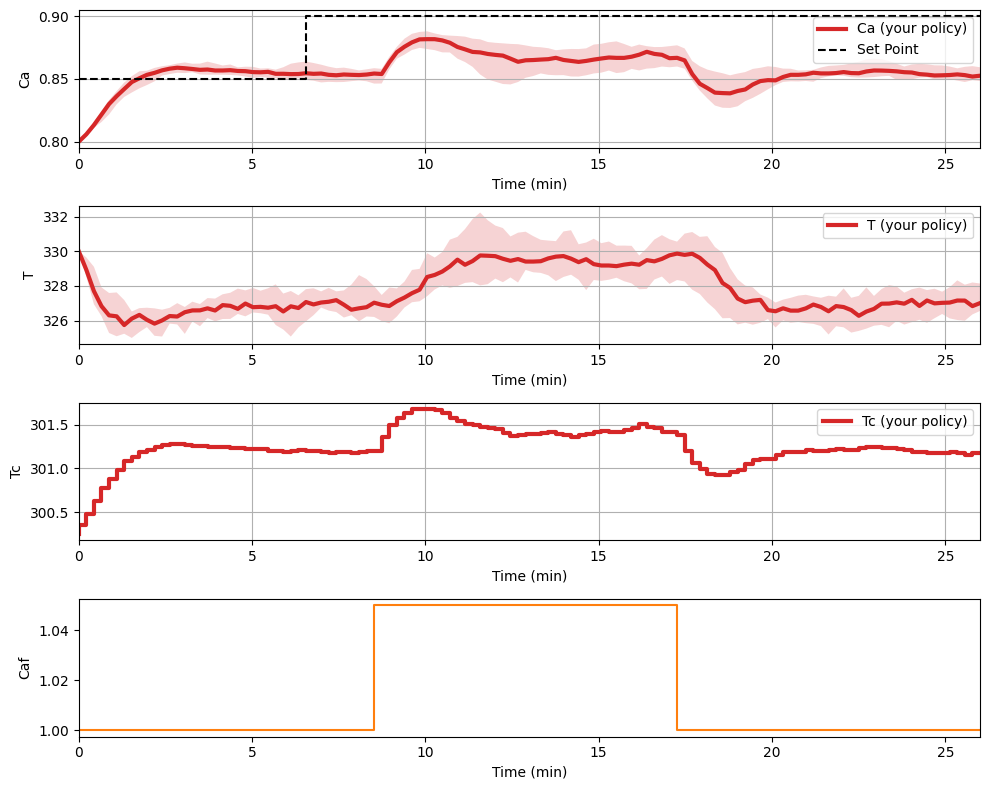

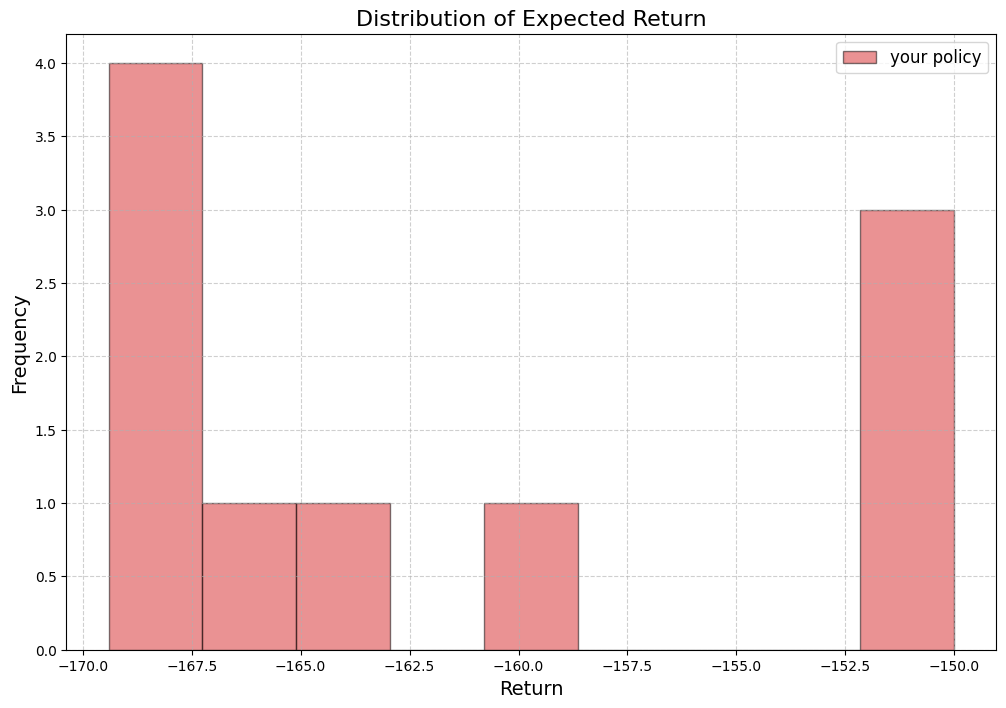

In [6]:
evaluator, data = env.plot_rollout({'your policy':your_policy}, reps = 10, oracle = False, dist_reward=True, MPC_params={'N':10,'R':0.1}) # Rollout your policy

### Your score!

In [7]:
res = data['your policy']['r'].mean()
print(f"Your final score is: {res:.2f} (larger the better).")

Your final score is: -161.57 (larger the better).
